## Time series - Laboratorio 2

Fernando E. Mancuso

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

In [3]:
data = pd.read_csv('demanda.csv', index_col = 'TIPO', parse_dates = True, dayfirst = True)
data.tail()

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
TIPO,,,,
2019-03-01,4004709.444,3044854.983,3072063.284,1.012163e+07
2019-04-01,3652724.519,2892482.731,3029687.889,9.574895e+06
2019-05-01,4356836.823,2973830.213,3055527.035,1.038619e+07
2019-06-01,4816838.191,2937048.667,2897618.673,1.065151e+07
2019-07-01,5704951.016,3288949.873,3035538.422,1.202944e+07


In [4]:
ts = data['TOTAL']
data.index = data.index.to_period(freq = 'M')
data.tail()

,Residencial,Comercial,Industrial/Comercial Grande,TOTAL
TIPO,,,,
2019-03,4004709.444,3044854.983,3072063.284,1.012163e+07
2019-04,3652724.519,2892482.731,3029687.889,9.574895e+06
2019-05,4356836.823,2973830.213,3055527.035,1.038619e+07
2019-06,4816838.191,2937048.667,2897618.673,1.065151e+07
2019-07,5704951.016,3288949.873,3035538.422,1.202944e+07


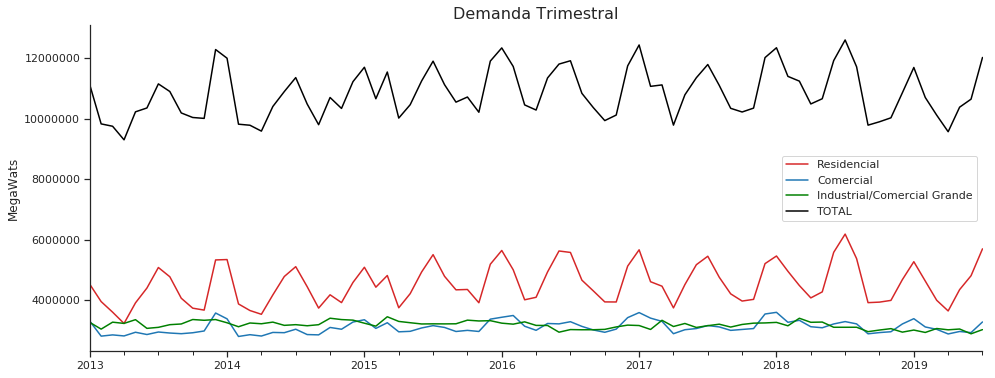

In [5]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.ticklabel_format(style = 'plain')

data['Residencial'].plot(color = red, label = 'Residencial')
data['Comercial'].plot(color = blue, label = 'Comercial')
data['Industrial/Comercial Grande'].plot(color = 'green', label = 'Industrial/Comercial Grande')
data['TOTAL'].plot(color = 'black', label = 'TOTAL')

ax.set_title('Demanda Trimestral', fontsize = 16)
ax.set_xlabel('')
ax.set_ylabel('MegaWats')
plt.legend(loc = 'best')

sns.despine()
plt.show()

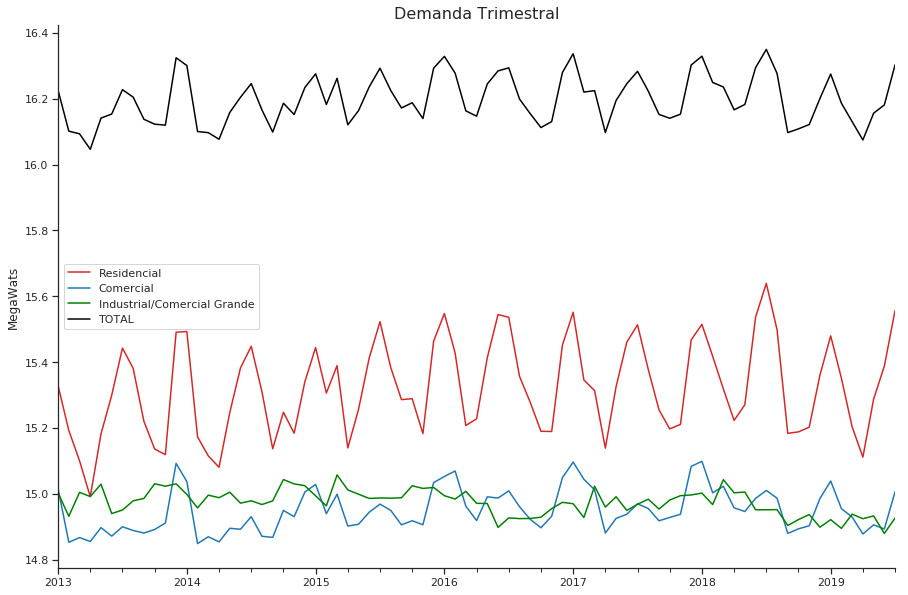

In [6]:
fig, ax = plt.subplots(figsize = (15, 10))

np.log(data['Residencial']).plot(color = red, label = 'Residencial')
np.log(data['Comercial']).plot(color = blue, label = 'Comercial')
np.log(data['Industrial/Comercial Grande']).plot(color = 'green', label = 'Industrial/Comercial Grande')
np.log(data['TOTAL']).plot(color = 'black', label = 'TOTAL')

ax.set_title('Demanda Trimestral', fontsize = 16)
ax.set_xlabel('')
ax.set_ylabel('MegaWats')
plt.legend(loc = 'best')

sns.despine()
plt.show()

### Descomposición

In [7]:
decomposition = sm.tsa.x13_arima_analysis(ts, x12path = '.')
[attr for attr in dir(decomposition) if not attr.startswith('_')]


/usr/local/lib/python3.5/dist-packages/statsmodels/tsa/x13.py:187: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


['irregular', 'observed', 'plot', 'results', 'seasadj', 'stdout', 'trend']

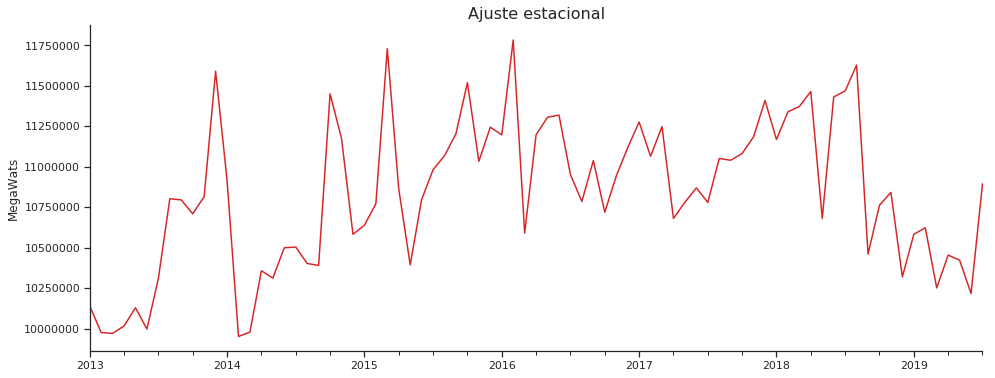

In [8]:
fig, ax = plt.subplots(figsize = (16, 6))
plt.ticklabel_format(style = 'plain')
decomposition.seasadj.plot(color = red)
ax.set_xlabel('')
ax.set_ylabel('MegaWats')
ax.set_title('Ajuste estacional', fontsize = 16)
sns.despine()
plt.show()

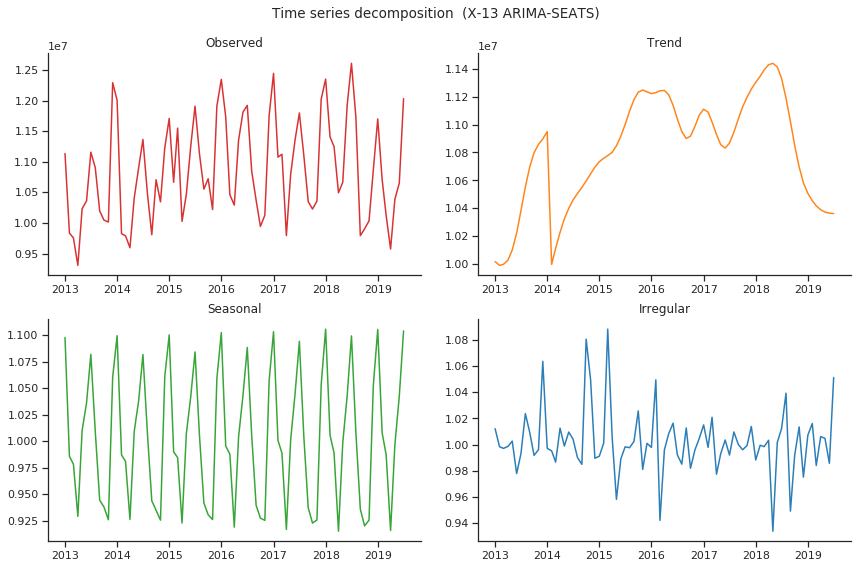

In [9]:
from plotting import plot_components_x13
plot_components_x13(decomposition)
plt.show()

In [10]:
z = decomposition.seasadj.copy()
z.index = ts.index.to_period(freq = 'M')

model_sm = sm.tsa.Holt(z).fit()
smoothed_sm = model_sm.fittedvalues
alpha_sm = model_sm.model.params['smoothing_level']
betha_sm = model_sm.model.params['smoothing_slope']
mse_sm = sm.tools.eval_measures.mse(ts,smoothed_sm)

model_sm.summary()

Dep. Variable:,endog,No. Observations:,79
Model:,Holt,SSE,11014754117819.137
Optimized:,True,AIC,2035.204
Trend:,Additive,BIC,2044.682
Seasonal:,None,AICC,2036.371
Seasonal Periods:,None,Date:,"Thu, 31 Oct 2019"
Box-Cox:,False,Time:,15:51:49
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3839538,alpha,True
smoothing_slope,0.000000,beta,True


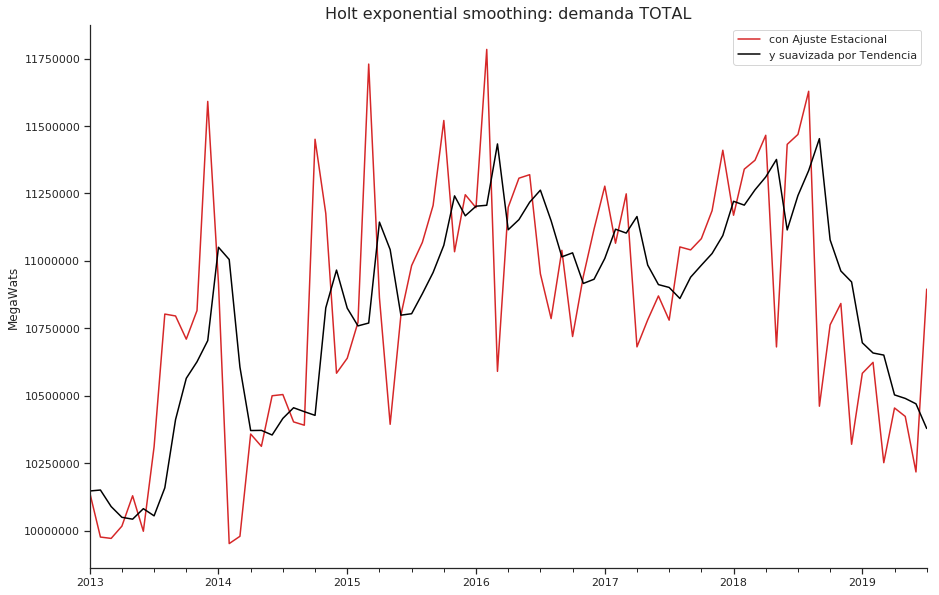

In [11]:
fig, ax = plt.subplots(figsize = (15, 10))
plt.ticklabel_format(style = 'plain')

ax.set_title('Holt exponential smoothing: demanda TOTAL', fontsize = 16)

z.plot(color = '#D62728', label = 'con Ajuste Estacional')
smoothed_sm.plot(color = 'black', label = 'y suavizada por Tendencia')

plt.legend(loc = 'best')
ax.set_xlabel('')
ax.set_ylabel('MegaWats')

sns.despine()
plt.show()


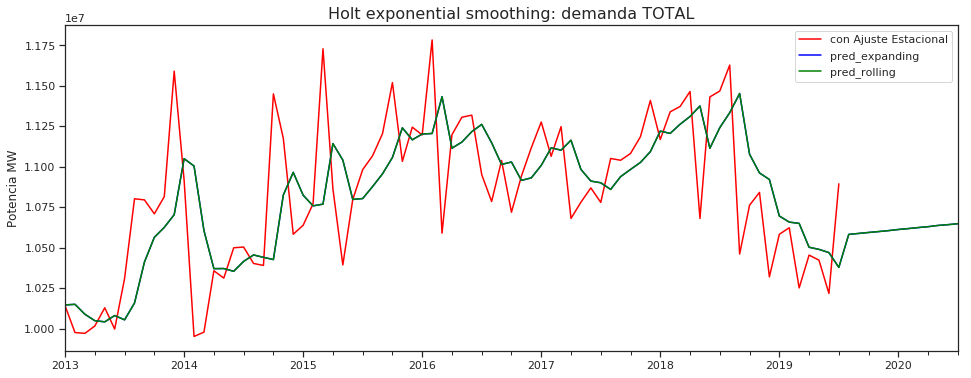

In [12]:
h = 12
w = h * 12
Z = z

model = sm.tsa.Holt
pred_index = Z.index[-1] + np.array(range(1, h + 1))
pred_rolling = pd.Series(0, index = pred_index)
pred_expanding = pd.Series(0, index = pred_index)
orig_fit = None

for i in range(0, h):
    current = pd.concat([Z, pred_expanding.head(i)])
    expanding = model(current).fit()
    if i == 0:
        orig_fit = expanding.fittedvalues
        
    rolling = model(current.tail(w)).fit()
    pred_expanding.update(expanding.forecast(1))
    pred_rolling.update(rolling.forecast(1))
    
ax = Z[-w:].plot(color = 'red', figsize = (16, 6), label = 'con Ajuste Estacional')
ax.set_title('Holt exponential smoothing: demanda TOTAL', fontsize = 16)
ax.set_xlabel('')
ax.set_ylabel('Potencia MW')

pd.concat([orig_fit[-w:], pred_expanding]).plot(ax = ax, color = 'blue', label = 'pred_expanding')
pd.concat([orig_fit[-w:], pred_rolling]).plot(ax = ax, color = 'green', label = 'pred_rolling')

plt.legend(loc = 'best')
plt.show()


## Diagnóstico

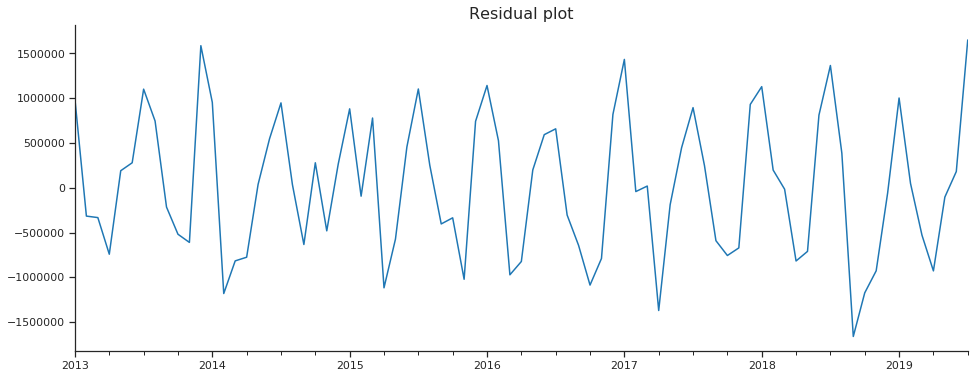

In [13]:
resid = (data['TOTAL'] - model_sm.fittedvalues)
fig, ax = plt.subplots(figsize = (16, 6))
resid.plot(color = blue)
ax.set_xlabel('')
ax.set_title('Residual plot', fontsize = 16)
sns.despine()
plt.show()


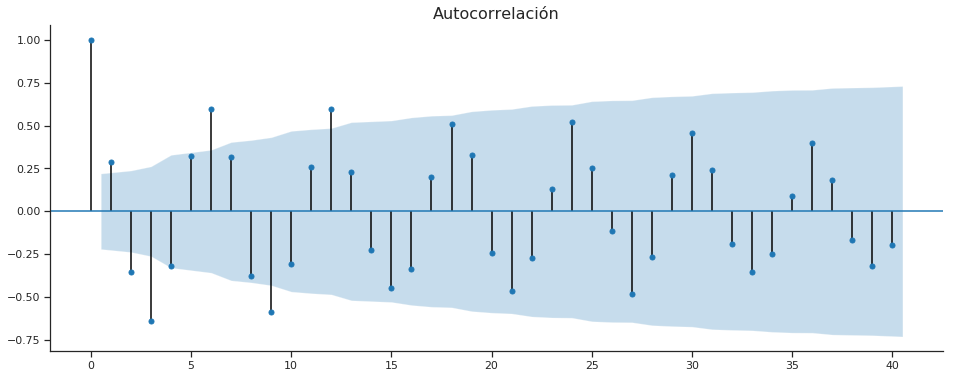

In [14]:
fig, ax = plt.subplots(figsize = (16, 6))
sm.graphics.tsa.plot_acf(resid, lags = 40, ax = ax)
ax.set_title('Autocorrelación', fontsize = 16)
sns.despine()
plt.show()

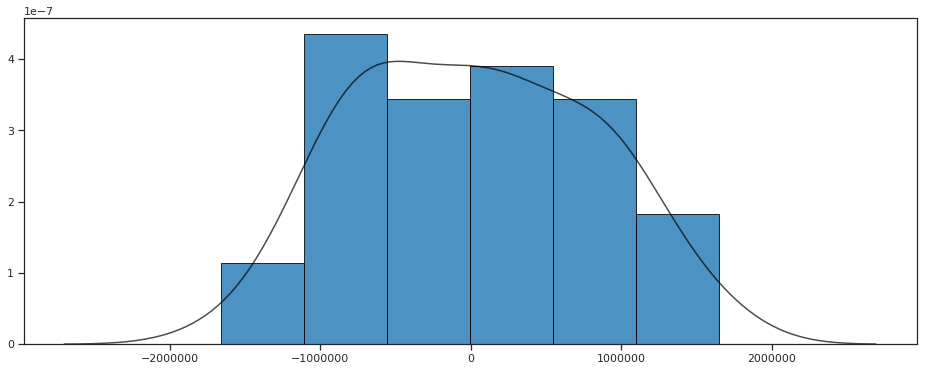

In [15]:
from plotting import histogram
fig, ax = plt.subplots(figsize = (16, 6))
sns.distplot(resid, ax = ax, hist_kws = {'alpha': 0.8, 'edgecolor':'black', 'color': blue},  
                 kde_kws = {'color': 'black', 'alpha': 0.7})
plt.show()

## Validación

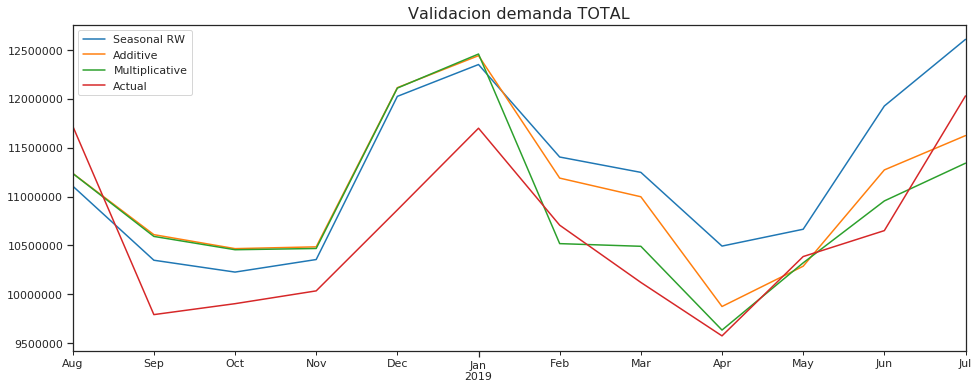

In [16]:
initial_value = data['TOTAL'].index[-round(len(data['TOTAL']) / 12 * .2) * 12]
validation = data['TOTAL'][initial_value:].index
start = data['TOTAL'].index.get_loc(initial_value) 

seasonal_random_walk = []
additive_holt_winters = []
multiplicative_holt_winters = []
actual= []

for i in range(start, len(data['TOTAL'])):
    
    actual.append(data['TOTAL'].iloc[i])
    
    seasonal_random_walk.append(data['TOTAL'].iloc[i-12])
    
    model = sm.tsa.ExponentialSmoothing(data['TOTAL'].iloc[:i], trend = 'add', damped = False, seasonal = 'add', seasonal_periods = 12).fit()
    additive_holt_winters.append(model.forecast(1)[0])
    
    model = sm.tsa.ExponentialSmoothing(data['TOTAL'].iloc[:i], trend = 'add', damped = False, seasonal = 'mul', seasonal_periods = 12).fit()
    multiplicative_holt_winters.append(model.forecast(1)[0])
    

columns = ['Seasonal RW', 'Additive', 'Multiplicative', 'Actual']
results = np.vstack([seasonal_random_walk, additive_holt_winters, multiplicative_holt_winters, actual]).T
results = pd.DataFrame(results, columns = columns, index = validation)

fig, ax = plt.subplots(figsize = (16, 6))
plt.ticklabel_format(style = 'plain')

results.plot(ax = ax)
ax.set_title('Validacion demanda TOTAL', fontsize = 16)
ax.set_xlabel('')

plt.show()


In [17]:
table = pd.DataFrame(0.0, index = results.columns[:-1], columns = ['RMSE', 'SE'])
for i in range(len(results.columns)-1):
    table.iloc[i, 0] = sm.tools.eval_measures.rmse(results.iloc[:, i], results.iloc[:, -1])
    table.iloc[i, 1] = (results.iloc[:, i] - results.iloc[:, -1]).sem()
table


,RMSE,SE
Seasonal RW,779964.343846,148054.667334
Additive,657481.478050,150961.652292
Multiplicative,594538.756771,161497.230317
